# ISLP - Chapter 8 - Exercise 10
### Author: pzuehlke

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

In [3]:
hitters = pd.read_csv("Hitters.csv")
hitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [4]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


__10 (a):__

In [5]:
hitters = hitters.dropna(subset=["Salary"])
hitters["Salary"] = np.log(hitters["Salary"])
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,6.163315,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,6.173786,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,6.214608,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,4.516339,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,6.620073,A


__10 (b):__ Note that the statement doesn't ask for a random split of the data
as in most exercises, but rather for the first $ t = 200 $ observations to go into
the training data.

In [6]:
X = hitters.drop(["Salary"], axis=1)
X = pd.get_dummies(X)
y = hitters["Salary"]

t = 200
X_train = X.iloc[:t]
y_train = y.iloc[:t]
X_test = X.iloc[t:]
y_test = y.iloc[t:]

__10 (c):__ To train the boosted trees, we choose eleven representative values of
the shrinkage parameter $ \lambda $ from $ 10^{-3} $ to $ 1 $ which are equally
spaced when using a logarithmic scale. The following code takes seven seconds to
run on my computer.

In [90]:
exponents = np.linspace(-3, 0, 11)
lambdas = 10**exponents
boosting_models = []  # We will need this to find the best model later
training_mses = []
test_mses = []  # To be used in item (d)

for shrinkage_value in lambdas:
    gbr = GradientBoostingRegressor(
        n_estimators=1000, learning_rate=shrinkage_value, max_depth=4, random_state=0
    )
    gbr.fit(X_train, y_train)
    boosting_models.append(gbr)
    train_pred = gbr.predict(X_train)
    train_mse = mean_squared_error(y_train, train_pred)
    training_mses.append(train_mse)
    # This part will only be used in item (d):
    test_pred = gbr.predict(X_test)
    test_mse = mean_squared_error(y_test, test_pred)
    test_mses.append(test_mse)

Now we plot the resulting training MSEs as described in the statement using a logarithmic scale on both axes:

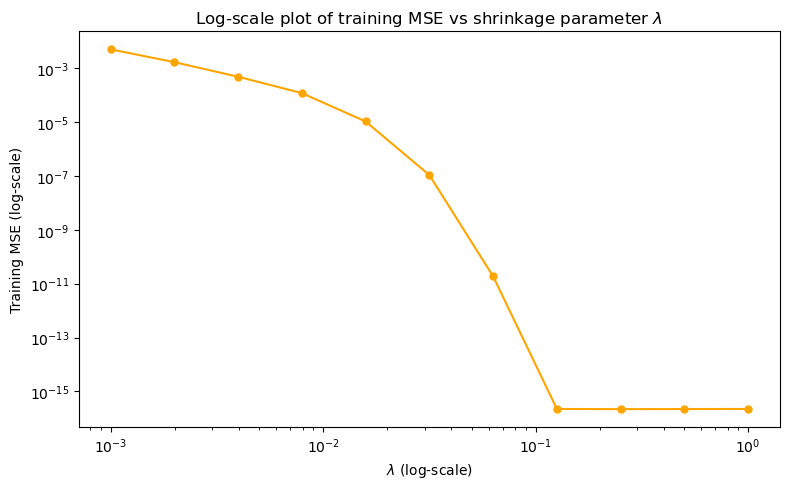

In [94]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(lambdas, training_mses, marker='o', color="orange", ms=5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$ \\lambda $ (log-scale)")
ax.set_ylabel("Training MSE (log-scale)")
ax.set_title("Log-scale plot of training MSE vs shrinkage parameter $ \\lambda $")
plt.tight_layout()
plt.show()

From the plot it seems that the best training MSEs are achieved for the final
three values of $ \lambda $, and that these are quite similar to each other. Let's verify this numerically:

In [95]:
for i, shrinkage_parameter in enumerate(lambdas):
    print(f"Training MSE for lambda = {shrinkage_parameter:.3f}:  {training_mses[i]:.2e}")

Training MSE for lambda = 0.001:  5.09e-03
Training MSE for lambda = 0.002:  1.69e-03
Training MSE for lambda = 0.004:  4.88e-04
Training MSE for lambda = 0.008:  1.20e-04
Training MSE for lambda = 0.016:  1.06e-05
Training MSE for lambda = 0.032:  1.08e-07
Training MSE for lambda = 0.063:  1.87e-11
Training MSE for lambda = 0.126:  2.21e-16
Training MSE for lambda = 0.251:  2.18e-16
Training MSE for lambda = 0.501:  2.20e-16
Training MSE for lambda = 1.000:  2.21e-16


__10 (d):__ We now repeat the work in item (c) for the test MSEs. In the plot
below only the $ x $-axis employs a log-scale:

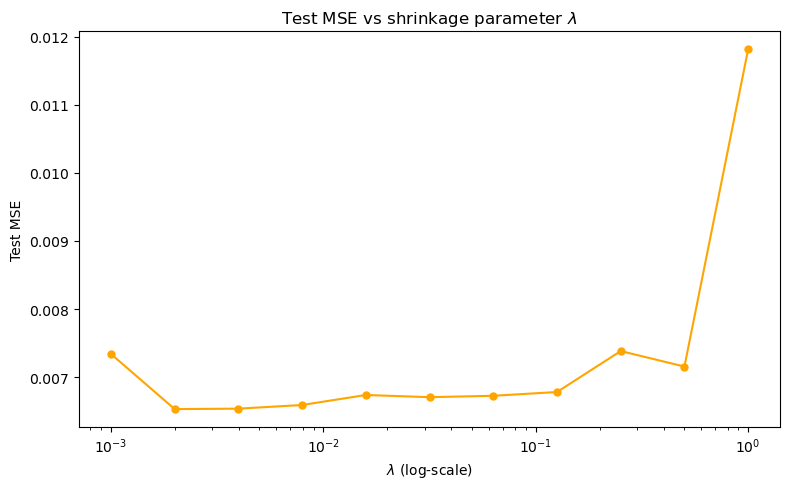

In [96]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(lambdas, test_mses, marker='o', color="orange", ms=5)
ax.set_xscale("log")
ax.set_xlabel("$ \\lambda $ (log-scale)")
ax.set_ylabel("Test MSE")
ax.set_title("Test MSE vs shrinkage parameter $ \\lambda $")
plt.tight_layout()
plt.show()

In [97]:
for i, shrinkage_parameter in enumerate(lambdas):
    print(f"Test MSE for lambda = {shrinkage_parameter:.3f}:  {test_mses[i]:.2e}")

Test MSE for lambda = 0.001:  7.34e-03
Test MSE for lambda = 0.002:  6.53e-03
Test MSE for lambda = 0.004:  6.54e-03
Test MSE for lambda = 0.008:  6.59e-03
Test MSE for lambda = 0.016:  6.74e-03
Test MSE for lambda = 0.032:  6.71e-03
Test MSE for lambda = 0.063:  6.73e-03
Test MSE for lambda = 0.126:  6.78e-03
Test MSE for lambda = 0.251:  7.38e-03
Test MSE for lambda = 0.501:  7.16e-03
Test MSE for lambda = 1.000:  1.18e-02


In [100]:
best_index = np.argmin(test_mses)
best_boost_model = boosting_models[best_index]
best_lambda = lambdas[best_index]
print(f"Test MSE for best lambda ({best_lambda:.3f}): {test_mses[best_index]:.2e}")

Test MSE for best lambda (0.002): 6.53e-03


__10 (f):__ The predictor `CAtBat` (Career At Bats) dominates all others in
terms of importance for predicting a player's salary in the boosted model.  It
represents the number of times at bat during the player's career:

In [101]:
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_boost_model.feature_importances_
})
feature_importances = feature_importances.sort_values("Importance", ascending=False)
feature_importances.head(5)

,Feature,Importance
7,CAtBat,0.641144
10,CRuns,0.059926
11,CRBI,0.054429
0,AtBat,0.051201
5,Walks,0.040922


__10 (f):__ Fitting a multiple linear regression model (ch. 3) and lasso
regression models for several values of $ \lambda $ (ch. 6) we obtain test MSEs
of $ 15 \times 10^{-3} $ and $ 12.7 \times 10^{-3} $, which is much worse than of
the boosting model.

In [111]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_test_mse = mean_squared_error(y_test, lr_pred)
print(f"Multiple linear regression test MSE: {lr_test_mse:.4f}")

Multiple linear regression test MSE: 0.0150


In [125]:
best_alpha = 0
best_lasso_test_mse = np.inf
for alpha in np.linspace(0.1, 10, 101):
    lasso = Lasso(alpha=alpha, max_iter=10_000)
    lasso.fit(X_train, y_train)
    lasso_pred = lasso.predict(X_test)
    lasso_test_mse = mean_squared_error(y_test, lasso_pred)
    if lasso_test_mse < best_lasso_test_mse:
        best_lasso_test_mse = lasso_test_mse
        best_alpha = alpha
print(f"Lasso regression test MSE (alpha = {best_alpha}): {best_lasso_test_mse:.4f}")

Lasso regression test MSE (alpha = 6.139): 0.0127


__10 (g):__ The test MSE using a bagging model with $ 1000 $ trees is $ 7.16 \times 10^{-3} $, which is worse
than but still competitive with the boosting model's test MSE of $ 6.53 \times 10^{-3} $.

In [104]:
rf = RandomForestRegressor(
    n_estimators=1000,
    max_features=None,  # bagging
    random_state=0
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)

print(f"Bagging test MSE: {rf_mse:.3e}")

Bagging test MSE: 7.160e-03


We conclude that for predicting a player's salary using this dataset, boosting
seems to be the best approach among the ones that we considered. 